# Sample Code

## 基礎建設

In [1]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [2]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2022-01-01 08:44:09--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv.3’

All_Beauty.csv.3    100%[===================>]  14.78M  19.8MB/s    in 0.7s    

2022-01-01 08:44:10 (19.8 MB/s) - ‘All_Beauty.csv.3’ saved [15499476/15499476]

--2022-01-01 08:44:10--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz.3’

meta_All_Beauty.jso 100%[===================>]   9.85M  15.2MB/s    in 0.6s   

In [3]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [4]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [5]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

In [6]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

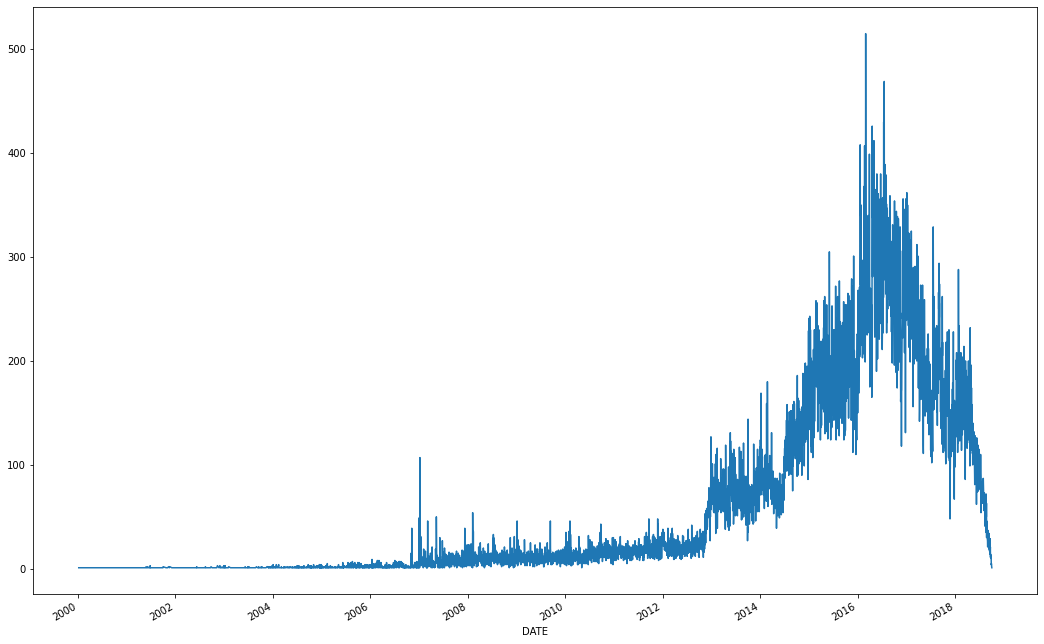

In [52]:
ratings.groupby('DATE').count()['asin'].plot(figsize=(18,12))

In [78]:
metadata_subset = ratings[
    (ratings['DATE'] > '2016-12-31')
]
metadata_subset = metadata_subset.drop_duplicates('asin')
metadata_subset['asin']

7         014789302X
32        1620213982
4859      9790787006
5100      B000050FDY
5176      B000050FDT
             ...    
371322    B01HIUEEHO
371327    B01HIWKGOM
371329    B01HJ1K3YK
371330    B01HJ84SGM
371336    B01HJEGTYK
Name: asin, Length: 14615, dtype: object

## 資料切分

In [7]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

In [116]:
# find top 10 reviews product in past 180 days
import datetime
end_date = ratings_trainings['DATE'].max()
start_date = end_date - datetime.timedelta(180)
# filter data in selected time
ratings_past180d = ratings_trainings[
    (ratings_trainings['DATE'] >= start_date) & 
    (ratings_trainings['DATE'] <= end_date)
]
# find top 10 review numbers products
top10_reviews = ratings_past180d.groupby('asin').size() \
                        .sort_values(ascending=False).index.to_list()[0:10]
top10_reviews

['B01DKQAXC0',
 'B006IB5T4W',
 'B00W259T7G',
 'B0195R1FT8',
 'B0012Y0ZG2',
 'B001QY8QXM',
 'B000050FDY',
 'B000I6AZHE',
 'B012Z7IHHI',
 'B00GW58YC8']

## 產生推薦

In [126]:
# data preprocessing before tf-idf
import string
import re
import nltk

## remove duplicate product
df = metadata[['asin','description', 'title']].drop_duplicates('title')

## combine "description" and "title" to a new sentence and store it in a new column named title_desc
df['title_desc'] = df['title'] + df['description'][0]

## select subset
df = df.loc[df['asin'].isin(metadata_subset['asin'])]

## transfer all words to lowercase
df['title_desc'] = df['title_desc'].str.lower()

## remove punctuation
punctuation_table = str.maketrans('', '', string.punctuation)
df['title_desc'] = df['title_desc'].str.translate(punctuation_table)

## replace number to "num"
df['title_desc'] = [re.sub(r'\d+', 'num', string) for string in df['title_desc']]

## remove stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english') + ['reuter', '\x03'])

def remove_nuisance_words(string):
    remove_nuisance = ''
    for word in string.split():
        if word not in stopwords:
            remove_nuisance += ' ' + word
    return remove_nuisance

df['title_desc'] = [remove_nuisance_words(string) for string in df['title_desc']]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [128]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 計算商品用標題所表示的 tfidf 矩陣
tf = TfidfVectorizer(analyzer='word')
tfidf_matrix = tf.fit_transform(df['title_desc'])

# 計算商品間的相似程度
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(tfidf_matrix)
mapping = pd.Series(df.index,index = df['asin'])

# 每個商品回傳 k 個最相近的商品
def recommend_item(item_input, k=2):
    try:
        item_index = mapping[item_input]
        similarity_score = list(enumerate(similarity_matrix[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        item_indices = [i[0] for i in similarity_score]
        return (df['asin'].iloc[item_indices].tolist())
    except:
        return []

# 利用使用者購買過的商品產生推薦
def recommend_items(items, k):
    res = []
    for d in items:
        res.extend(recommend_item(d, k))
    return res

In [129]:
def recommender(training_data, users=[], k=10):
    recommendations = {}
    
    ratings_trainings = training_data
    
    for user in users:
        # print(metadata[metadata['asin'].isin(ratings_trainings[ratings_trainings['reviewerID'] == user]['asin'].tolist())]['asin'].tolist())
        # content based
        recom_list = recommend_items(metadata[metadata['asin'].isin(ratings_trainings[ratings_trainings['reviewerID'] == user]['asin'].tolist())]['asin'].tolist(), k)
        if recom_list:
            recommendations[user] = recom_list
        else:
            # recommend products by rule-based if content-based doesn't work
            recommendations[user] = top10_reviews
    return recommendations

ratings_by_user = recommender(ratings_trainings, users)

## 結果評估

In [130]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings_by_user, ratings_by_user)

0.09661016949152543

# Content-based推薦效果不佳之原因推論

In [136]:
# 從recommender函數print出資訊，以確認原因
def recommender(training_data, users=[], k=10):
    recommendations = {}

    ratings_trainings = training_data

    # 新增此行，紀錄training data中，曾經留下評論的目標使用者有多少人
    users_ever_bought_product = 0
    
    for user in users:
        # print(len(metadata[metadata['asin'].isin(ratings_trainings[ratings_trainings['reviewerID'] == user]['asin'].tolist())]['asin'].tolist()))
        if len(metadata[metadata['asin'].isin(ratings_trainings[ratings_trainings['reviewerID'] == user]['asin'].tolist())]['asin'].tolist()) > 0:
            users_ever_bought_product += 1
        # content based
        recom_list = recommend_items(metadata[metadata['asin'].isin(ratings_trainings[ratings_trainings['reviewerID'] == user]['asin'].tolist())]['asin'].tolist(), k)
        if recom_list:
            recommendations[user] = recom_list
        else:
            # recommend products by rule-based if content-based doesn't work
            recommendations[user] = top10_reviews
    print('測試資料集之中，在訓練資料集內曾經有評論過商品的人數: ', users_ever_bought_product)
    print('測試資料集總人數: ', len(users))
    return recommendations

ratings_by_user = recommender(ratings_trainings, users)

測試資料集之中，在訓練資料集內曾經有評論過商品的人數:  38
測試資料集總人數:  584
